# Autoencoders


# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных 


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разобьём выборку картинок на train и val, выведем несколько картинок в output, чтобы посмотреть, как они выглядят, и приведем картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
#train/val
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

#dataloader
train_loader = torch.utils.data.DataLoader(torch.FloatTensor(np.rollaxis(train_photos, 3, 1)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.FloatTensor(np.rollaxis(val_photos, 3, 1)), batch_size=32)

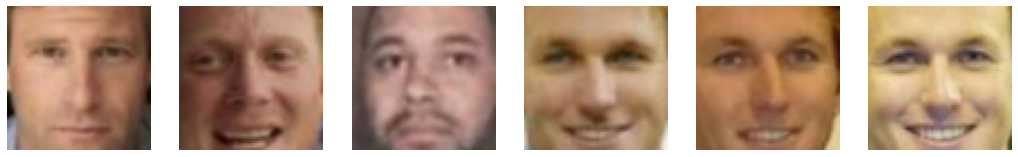

In [ ]:
#visual
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])
plt.show();

## 1.2. Архитектура модели
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


автоэнкодер выглядит вот так

In [ ]:
dim_code =  64

Реализуем autoencoder. 

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3),  
            nn.ReLU(),
            nn.Conv2d(16, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, dim_code*2, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim_code*2, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3)
        )

        
    def forward(self, x):
        #x = x.float()
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)        
        return reconstruction, latent_code

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

## 1.3 Обучение 

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(batch.to(device))
        loss = criterion(reconstruction, batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for x_batch in val_loader:
          reconstruction, latent_code = autoencoder(x_batch.to(device))
          loss = criterion(reconstruction, x_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10 [00:00<?, ?it/s]

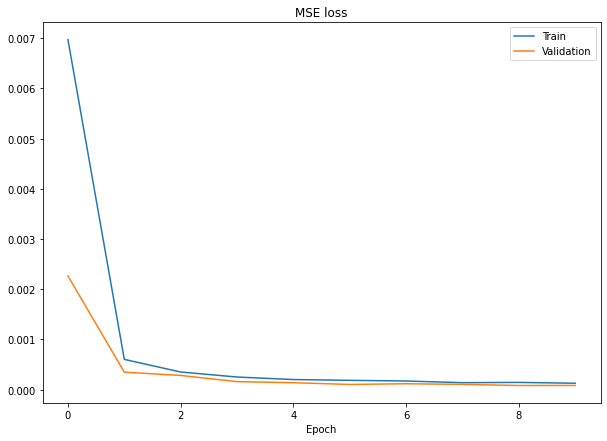

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstruction, lat_space = autoencoder(batch.to(device))
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

In [ ]:
ground_truth = np.rollaxis(ground_truth, 1, 4)
result = np.rollaxis(result, 1, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


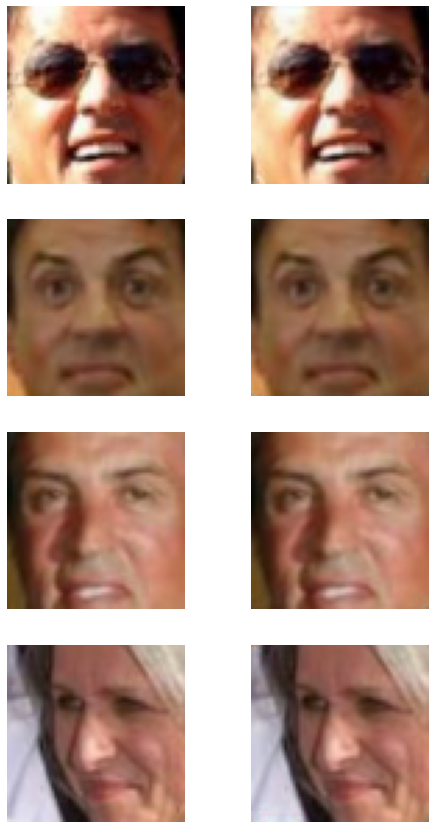

In [ ]:
#visual

plt.figure(figsize=(8, 15))
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(ground_truth[i])
    plt.axis("off")
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(result[i])
    plt.axis("off")
    
plt.show();

Not bad, right? 

## 1.4. Sampling 

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:


In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space

z = np.random.randn(25, 128, 58, 58)
z = torch.FloatTensor(z)*lat_space.std(axis=0) + lat_space.mean(axis=0)

In [ ]:
output= autoencoder.decoder(z.to(device))

In [ ]:
output=output.permute(0, 2, 3, 1)

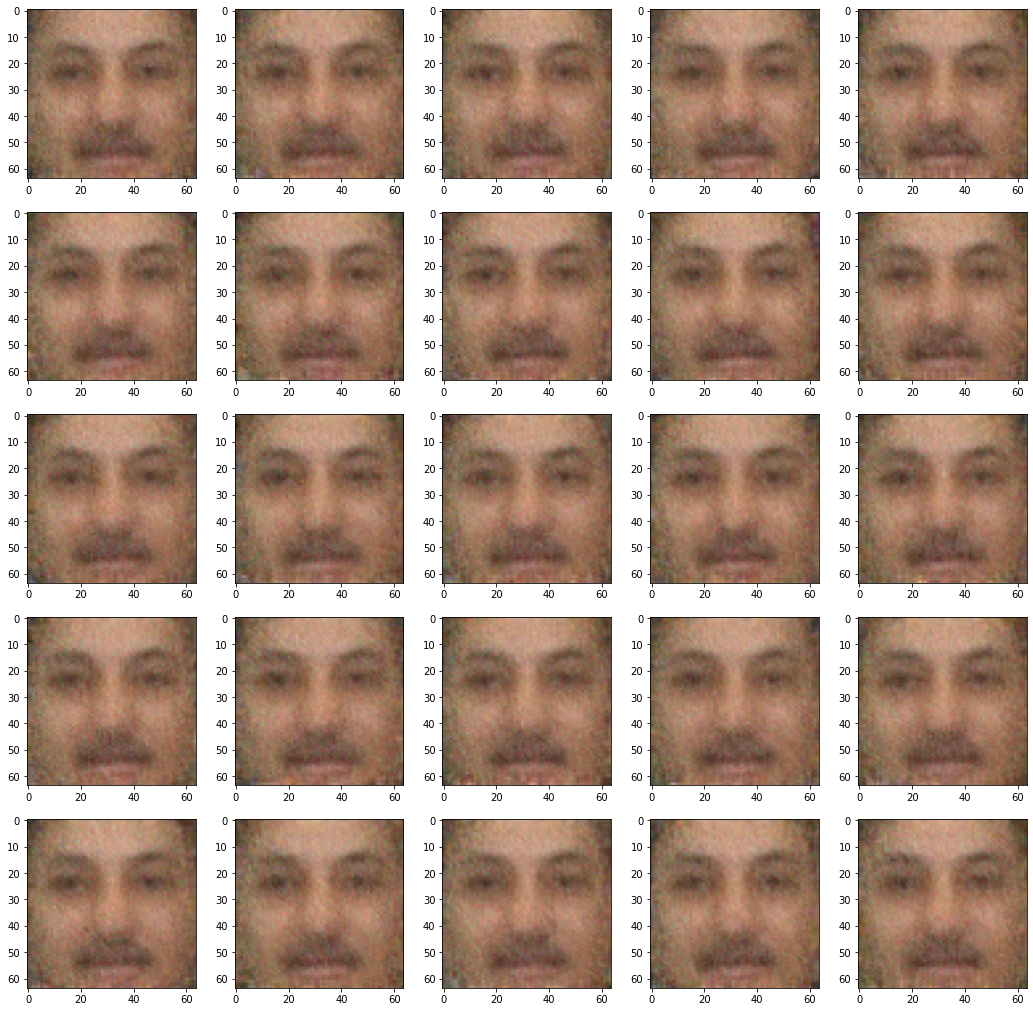

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(output[i].cpu().detach().numpy())

plt.show()

## Time to make fun!

Давайте научимся пририсовывать людям улыбки.

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки".

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки.

4. А теперь приделаем улыбку грустному человеку.

In [ ]:
smile_ind = val_attrs[val_attrs.Smiling>=0.99].index - 11828

In [ ]:
no_smile_ind = val_attrs[val_attrs.Smiling<=0.99].index - 11828

In [ ]:
smile_ind = smile_ind[:30]
no_smile_ind = no_smile_ind[:30]

In [ ]:
smile = []
no_smile = []
for i,j in zip(smile_ind, no_smile_ind):
  if smile == []:
    smile = [val_photos[i]]
  else:
    smile.append(val_photos[i])
  if no_smile == []:
    no_smile = [val_photos[j]]
  else:
    no_smile.append(val_photos[j])

In [ ]:
smile = np.array(smile)
no_smile = np.array(no_smile)

In [ ]:
smile_loader = torch.utils.data.DataLoader(torch.FloatTensor(np.rollaxis(smile, 3, 1)), batch_size=32)
no_smile_loader = torch.utils.data.DataLoader(torch.FloatTensor(np.rollaxis(no_smile, 3, 1)), batch_size=32)

In [ ]:
autoencoder.eval()
smile_space = []
i = 0
with torch.no_grad():
    for batch in smile_loader:
        reconstruction, smile_space_i = autoencoder(batch.to(device))
        if smile_space == []:
          smile_space = smile_space_i.mean(axis=0)
        else:
          smile_space + smile_space_i.mean(axis=0)
        i+=1
smile_space = smile_space/i

In [ ]:
autoencoder.eval()
no_smile_space = []
i = 0
with torch.no_grad():
    for batch in no_smile_loader:
        reconstruction, no_smile_space_i = autoencoder(batch.to(device))
        if no_smile_space == []:
          no_smile_space = no_smile_space_i.mean(axis=0)
        else:
          no_smile_space + no_smile_space_i.mean(axis=0)
        i+=1
no_smile_space = no_smile_space/i

In [ ]:
smile_vec = smile_space - no_smile_space

In [ ]:
smile_new = no_smile_space + smile_vec

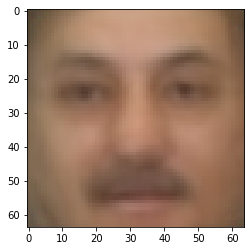

In [ ]:
no_smile_pic= autoencoder.decoder(no_smile_space.to(device))
no_smile_pic=no_smile_pic.permute(1,2,0)
plt.imshow(no_smile_pic.cpu().detach().numpy())

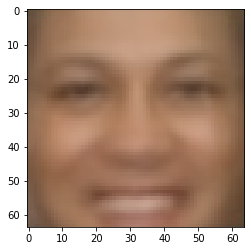

In [ ]:
new_smile_pic= autoencoder.decoder(smile_new.to(device))
new_smile_pic=new_smile_pic.permute(1,2,0)
plt.imshow(new_smile_pic.cpu().detach().numpy())

Всё получилось!

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение 

Реализуем VAE. 

In [ ]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=features*2))
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784)
        )

    def encode(self, x):
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.mul(0.5).exp_()
            esp = torch.randn(*mu.size())
            z = mu + std * esp
            return z
        else:
            return mu
        
    def decode(self, z):
        z = self.decoder(z)
        return torch.sigmoid(z) 
    
    def forward(self, x):
        x = self.flatten(x)
        mu, log_var = self.encode(x)
        z = self.gaussian_sampler(mu, log_var)
        return self.decode(z), mu, log_var

    def get_lat_vec(self, x):
        x = self.flatten(x)
        mu, log_var = self.encode(x)
        return self.gaussian_sampler(mu, log_var)

Определим лосс и его компоненты для VAE:

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
n_epochs = 50
train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          test_losses_per_epoch.append(loss.item())

    test_losses.append(np.mean(test_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

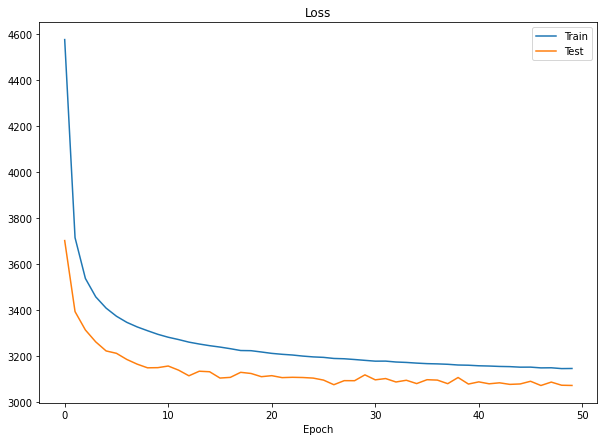

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test')

plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
        reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
        result = reconstruction.view(-1, 28, 28, 1)
        result = result.cpu().detach().numpy()
        ground_truth = batch[0].permute(0,2,3,1)
        ground_truth.numpy()
        break

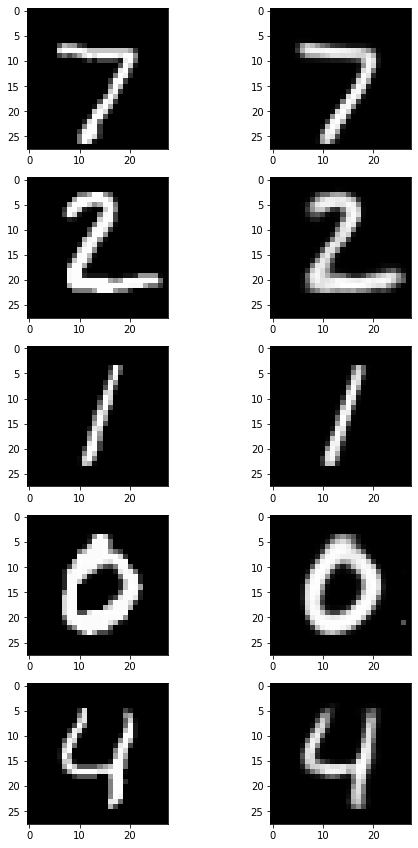

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 15))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt[:,:,0], cmap='gray')
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res[:,:,0], cmap='gray')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.FloatTensor(np.array([np.random.normal(0, 1, 16) for i in range(256)]))
output = autoencoder.decode(z.to(device))

In [ ]:
output.shape

torch.Size([256, 784])

In [ ]:
output = output.view(-1, 28, 28, 1)

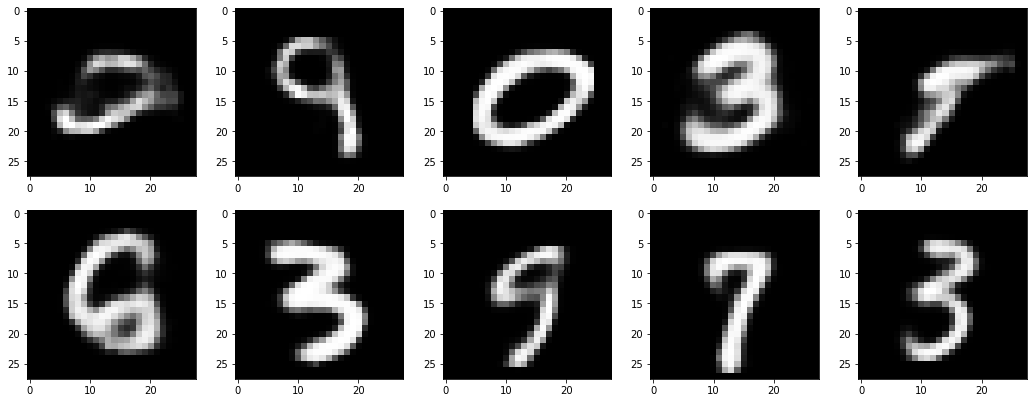

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(5, 5, i + 1)
  plt.imshow(output[i][:,:,0].cpu().detach().numpy(), cmap='gray')
plt.show()

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Наша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
i = 0
autoencoder.eval()
with torch.no_grad():
  for batch in test_loader:
    if i==0:
      lat_vec = autoencoder.get_lat_vec(batch[0].to(device)).numpy()
      Y = batch[1].numpy()
      i+=1
    else:
      lat_vec = np.vstack((lat_vec, autoencoder.get_lat_vec(batch[0].to(device)).numpy()))   
      Y = np.append(Y, batch[1].numpy(), axis=0)     

In [ ]:
X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(lat_vec)

In [ ]:
colors = {1:'blue', 2:'orange', 3:'green', 4:'red', 5:'purple', 6:'brown', 7:'pink', 8:'gray', 9:'olive', 0:'cyan'}

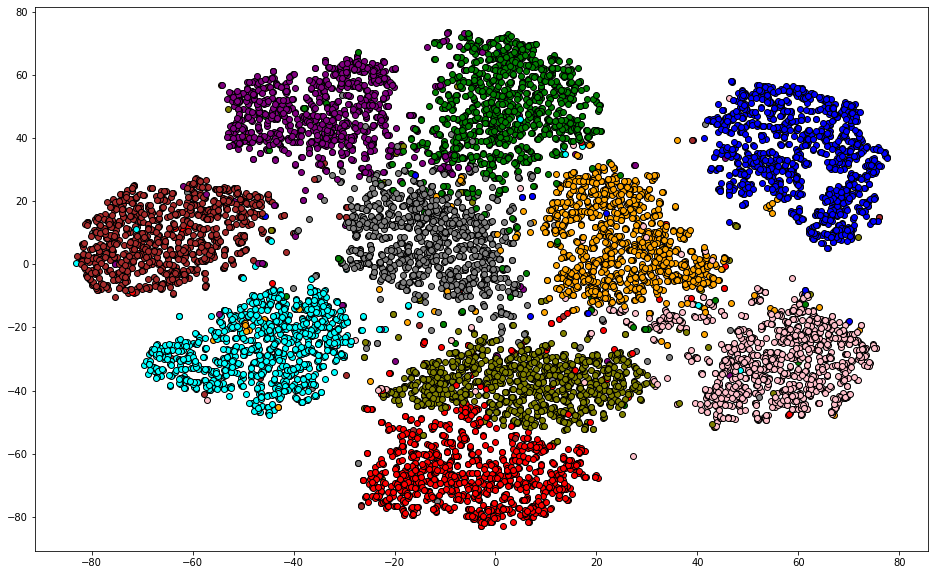

In [ ]:
plt.figure(figsize=(16, 10))
for x,y in zip(X, Y):
  plt.scatter(x[0], x[1], c = colors[y], edgecolors='black')
plt.show()

Очень красиво. Разделения на классы есть. Значит всё получилось. Но есть и выбросы.

## 2.3. Conditional VAE

Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

In [ ]:
features = 16
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.flatten = nn.Flatten()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=features*2))
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features+10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784)
        )

    def onehot(self, class_num, n=10):
      assert class_num.shape[1] == 1
      assert torch.max(class_num).item() < n

      onehot = torch.zeros(class_num.size(0), n)
      onehot.scatter_(1, class_num.data, 1)

      return onehot

    def encode(self, x, class_num):
        x = torch.cat((x, class_num), dim=1)
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.mul(0.5).exp_()
            esp = torch.randn(*mu.size())
            z = mu + std * esp
            return z
        else:
            return mu
    
    def decode(self, z, class_num):
        z = torch.cat((z, class_num), dim=-1)
        z = self.decoder(z)
        return torch.sigmoid(z) 

    def forward(self, x):
        class_num = self.onehot(x[1].view(-1, 1))
        class_num = class_num.to(device)
        x = self.flatten(x[0])
        x = x.to(device)
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        return mu, logsigma, self.decode(z, class_num)

    def get_lat_vec(self, x):
        class_num = self.onehot(x[1].view(-1, 1))
        class_num = class_num.to(device)
        x = self.flatten(x[0])
        x = x.to(device)
        mu, logsigma, class_num = self.encode(x, class_num)
        return self.gaussian_sampler(mu, logsigma)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
n_epochs = 50
train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          mu, logsigma, reconstruction = autoencoder(batch)
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          test_losses_per_epoch.append(loss.item())

    test_losses.append(np.mean(test_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

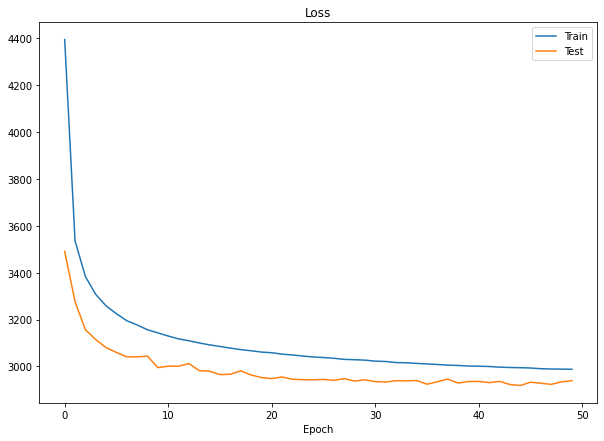

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test')

plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST мы можем попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
z = torch.FloatTensor(np.array([np.random.normal(0, 1, features)]))

In [ ]:
def decod_img(z, y_num):
    y =  torch.tensor(np.array(y_num), dtype=torch.int64)
    y = autoencoder.onehot(y.view(-1, 1))
    output = autoencoder.decode(z.to(device), y)
    output = output.view(-1, 28, 28, 1)
    plt.figure(figsize=(3, 3))
    plt.imshow(output[0][:,:,0].cpu().detach().numpy(), cmap='gray')

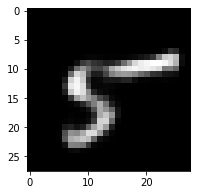

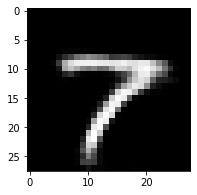

In [ ]:
decod_img(z, 5)
decod_img(z, 7)

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
i = 0
autoencoder.eval()
with torch.no_grad():
  for batch in test_loader:
    if i==0:
      lat_vec = autoencoder.get_lat_vec(batch).numpy()
      Y = batch[1].numpy()
      i+=1
    else:
      lat_vec = np.vstack((lat_vec, autoencoder.get_lat_vec(batch).numpy()))   
      Y = np.append(Y, batch[1].numpy(), axis=0)     

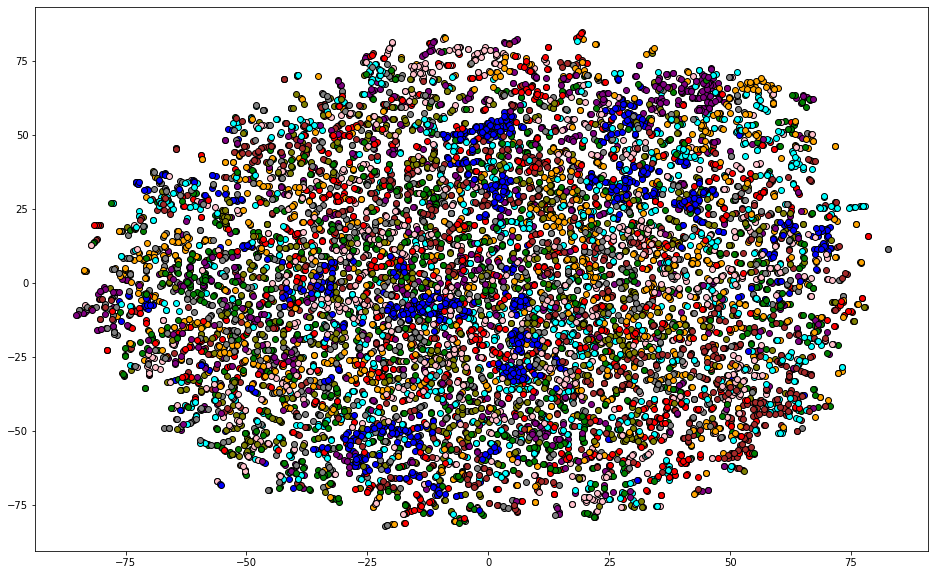

In [ ]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(lat_vec)
colors = {1:'blue', 2:'orange', 3:'green', 4:'red', 5:'purple', 6:'brown', 7:'pink', 8:'gray', 9:'olive', 0:'cyan'}
plt.figure(figsize=(16, 10))
for x,y in zip(X, Y):
  plt.scatter(x[0], x[1], c = colors[y], edgecolors='black')
plt.show()

Нет разделение на классы, в отличае от VAE.